<a href="https://colab.research.google.com/github/NguyenVanTrong21130581/ProjectDM/blob/main/Cardiomegaly_Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_data_path = '/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Test/Train'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Test/Test'
#/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Dataset/train
#/content/drive/MyDrive/Colab Notebooks/Cardiomegaly_Dataset/test

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [3]:


def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

In [4]:

valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=45)

In [5]:

# 128, 128
img_size = (224, 224)
batch_size = 8

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 216 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.
Found 216 validated image filenames belonging to 2 classes.


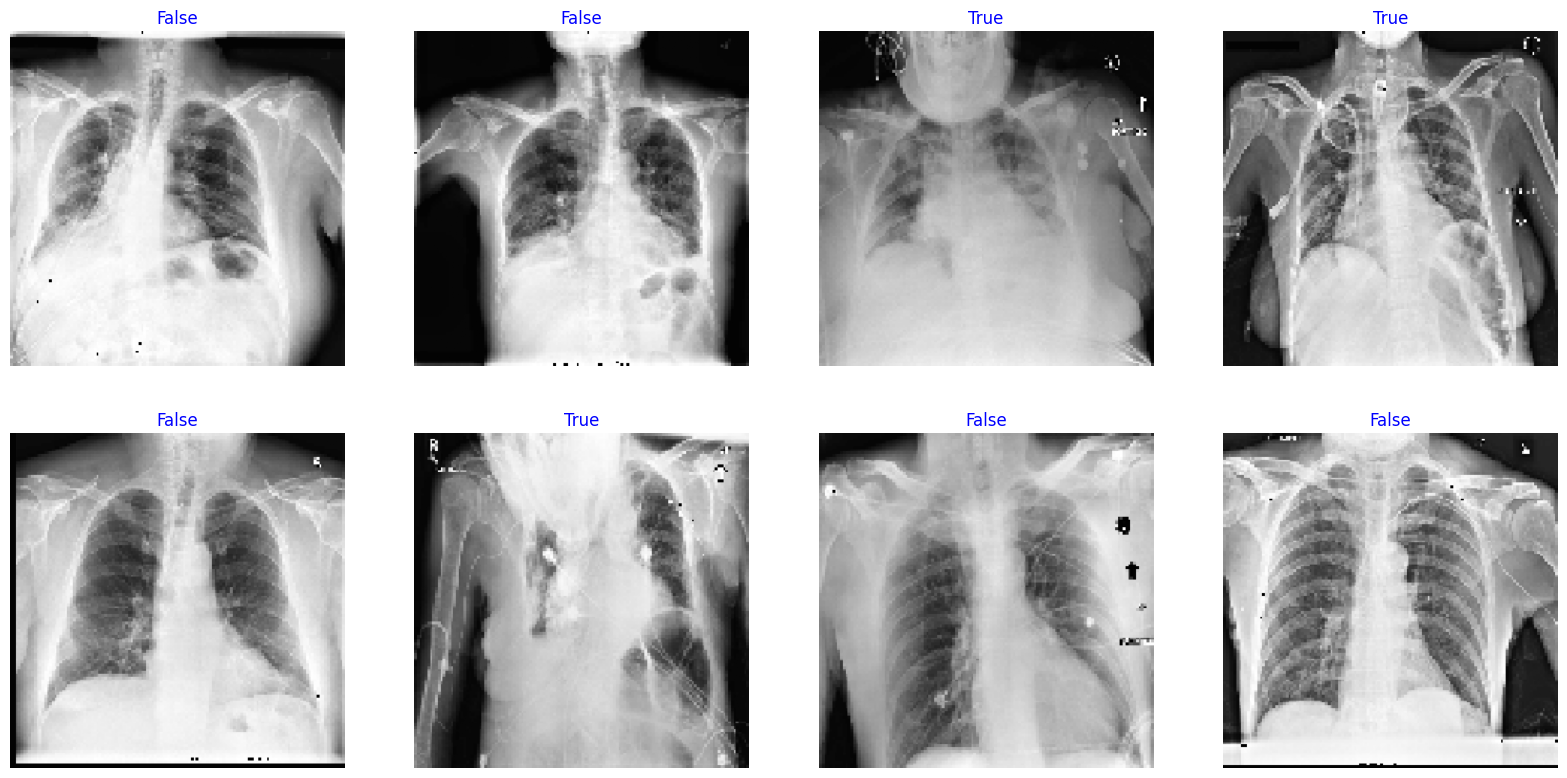

In [6]:

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

RANDOMFOREST

In [8]:
def extract_features(df, img_size=(224, 224)):
    features = []
    labels = []

    for idx, row in df.iterrows():
        img = cv2.imread(row['filepaths'])
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_flatten = img.flatten()
        features.append(img_flatten)
        labels.append(row['label'])

    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Fine-tune với Grid Search

In [9]:

param_grid = {
    'n_estimators': [50, 100, 150,200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_encoded)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best CV Accuracy: 0.7039


In [10]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=5,
    random_state=42,
)

rf_scores = cross_val_score(rf_model, X_train_scaled, y_train_encoded, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {np.mean(rf_scores):.4f} (±{np.std(rf_scores):.4f})")

rf_model.fit(X_train_scaled, y_train_encoded)

y_pred_rf = rf_model.predict(X_test_scaled)
rf_test_acc = rf_model.score(X_test_scaled, y_test_encoded)
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")

print("Classification Report for Random Forest:")
print(classification_report(y_test_encoded, y_pred_rf))

Random Forest CV Accuracy: 0.7039 (±0.0994)
Random Forest Test Accuracy: 0.6019
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.60      0.59      0.60       108
           1       0.60      0.61      0.61       108

    accuracy                           0.60       216
   macro avg       0.60      0.60      0.60       216
weighted avg       0.60      0.60      0.60       216



SVM

In [14]:
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'degree': [2, 3],
}

svm = SVC(class_weight='balanced', random_state=42)

svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_scaled, y_train_encoded)

print("Best SVM Parameters:", svm_grid.best_params_)
print(f"Best SVM CV Accuracy: {svm_grid.best_score_:.4f}")

best_svm = svm_grid.best_estimator_
best_svm.fit(X_train_scaled, y_train_encoded)

y_pred_svm = best_svm.predict(X_test_scaled)
print(f"SVM Test Accuracy: {best_svm.score(X_test_scaled, y_test_encoded):.4f}")
print("Classification Report for Fine-tuned SVM:")
print(classification_report(y_test_encoded, y_pred_svm))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best SVM Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM CV Accuracy: 0.7086
SVM Test Accuracy: 0.5833
Classification Report for Fine-tuned SVM:
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       108
           1       0.59      0.56      0.57       108

    accuracy                           0.58       216
   macro avg       0.58      0.58      0.58       216
weighted avg       0.58      0.58      0.58       216



KNN

In [15]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_train_scaled, y_train_encoded)

print("Best KNN Parameters:", knn_grid.best_params_)
print(f"Best KNN CV Accuracy: {knn_grid.best_score_:.4f}")

best_knn = knn_grid.best_estimator_
best_knn.fit(X_train_scaled, y_train_encoded)

y_pred_knn = best_knn.predict(X_test_scaled)
print(f"KNN Test Accuracy: {best_knn.score(X_test_scaled, y_test_encoded):.4f}")
print("Classification Report for Fine-tuned KNN:")
print(classification_report(y_test_encoded, y_pred_knn))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best KNN CV Accuracy: 0.6252
KNN Test Accuracy: 0.5694
Classification Report for Fine-tuned KNN:
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       108
           1       0.56      0.61      0.59       108

    accuracy                           0.57       216
   macro avg       0.57      0.57      0.57       216
weighted avg       0.57      0.57      0.57       216

